In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib as mpl
mpl.rcParams['axes.grid'] = True

# Symbolic Computation and Optimization

Core idea: make your program keep track of what computations you have performed.

In [2]:
from pydrake.all import (
    Variable
)
# Declare some Variables
x = Variable("x")
y = Variable("y")
# Declare an Expression
z = x + y**2
print "z: ", z
# Declare a Formula using z
z_equals_one = (z == 1)
print "formula: ", z_equals_one

z:  (x + pow(y, 2))
formula:  ((x + pow(y, 2)) = 1)


You can do simple things, like do evaluations or substitutions...

In [3]:
xi = 3.
yi = 4.
print "Using x = %f, y = %f..." % (xi, yi)
# Partial evaluation (specifying *some* variables)
print "Partial evaluation (for only x): z = ", z.EvaluatePartial({x:xi})
print "Partial evaluation (for only y): z = ", z.EvaluatePartial({y:yi})
# Full evaluation (specifying *all* variables)
print "Full evaluation: z = ", z.Evaluate({x:xi, y:yi})
print "Substituting x = y^2: z = ", z.Substitute({x:y**2})

Using x = 3.000000, y = 4.000000...
Partial evaluation (for only x): z =  (3 + pow(y, 2))
Partial evaluation (for only y): z =  (16 + x)
Full evaluation: z =  19.0
Substituting x = y^2: z =  (2 * pow(y, 2))


And you can ask for derivatives...

In [4]:
print "Derivative of z w.r.t. x: ", z.Differentiate(x)
print "Derivative of z w.r.t. y: ", z.Differentiate(y)
print "2nd derivative of z w.r.t. y: ", z.Differentiate(y).Differentiate(y)
print "You can ask for Jacobians if you want: ", z.Jacobian([x, y])

Derivative of z w.r.t. x:  1
Derivative of z w.r.t. y:  (2 * y)
2nd derivative of z w.r.t. y:  2
You can ask for Jacobians if you want:  [<Expression "1"> <Expression "(2 * y)">]


## Mathematical Programming

As you might guess, you can build this up to cool stuff! The primary thing we use this for is setting up and solving optimizations. By specifying an optimization (i.e. an objective + a list of constraints) symbolically, Drake figures out what class of optimization it is and dispatches to an appropriate solver.

http://drake.mit.edu/doxygen_cxx/group__solvers.html

In [10]:
from pydrake.all import (MathematicalProgram)
prog = MathematicalProgram()
# NewContinuousVariables spawns a 1x1 array of decision
# variables. We're more concerned with individual variables
# for this example, so take out the first element of that
# array to get the actual Variable.
x = prog.NewContinuousVariables(1, "x")[0]
prog.AddQuadraticCost(x**2)
prog.AddBoundingBoxConstraint(0., 1., x)
result = prog.Solve()
print "Result: ", result
print "Solver used: ", prog.GetSolverId().name()
print "Optimizing x: ", prog.GetSolution(x)

Result:  SolutionResult.kSolutionFound
Solver used:  OSQP
Optimizing x:  0.0


In [11]:
prog = MathematicalProgram()
x = prog.NewContinuousVariables(1, "x")[0]
prog.AddCost(x**4)
prog.AddBoundingBoxConstraint(0., 1., x)
result = prog.Solve()
print "Result: ", result
print "Solver used: ", prog.GetSolverId().name()
print "Optimizing x: ", prog.GetSolution(x)

Result:  SolutionResult.kSolutionFound
Solver used:  SNOPT
Optimizing x:  0.0


## SOS Stability Analysis Example

As you might guess, you can build this up to cool stuff! For example, after defining some dynamics, you can pass symbolic variables through it, and then do stability analysis.

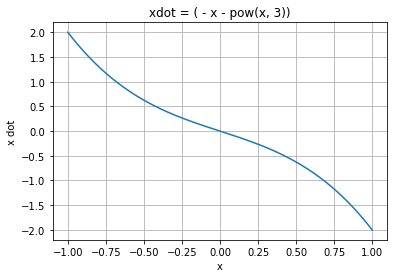

In [7]:
# Define dynamics
def dynamics(x):
    return -x**3 - x

# Do some visual inspection of this system
import matplotlib.pyplot as plt
import numpy as np
from pydrake.all import sin
x_sample = np.linspace(-1, 1, 1000)
f = np.array([dynamics(x_i) for x_i in x_sample])
plt.plot(x_sample, f)
plt.xlabel("x")
plt.ylabel("x dot")
plt.title("xdot = " + str(dynamics(Variable("x"))));

Verified globally stable!
Resulting Lyapunov function:  0.010768550023664367*x(0)^2 + -8.3573990004666846e-19*x(0)^3 + 0.012087454329122366*x(0)^4 + -2.5625928704208748e-14*1 + -2.7488648052396447e-18*x(0)


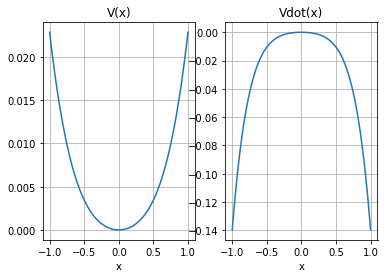

In [8]:
from pydrake.all import (
    MathematicalProgram,
    Polynomial,
    SolutionResult,
    Variables
)
prog = MathematicalProgram()
x = prog.NewIndeterminates(1, "x")[0]

# Search over Lyapunov candidates
(V, constraint) = prog.NewSosPolynomial(Variables([x]), 4)
# V(0) = 0
prog.AddConstraint(V.ToExpression().EvaluatePartial({x: 0.}) == 0.)
# V radially unbounded
prog.AddSosConstraint(V - 0.01*Polynomial(x**2))

# Calculate Vdot = dV/dx dx/dt
# Because V is a polynomial, its Jacobian is a Polynomial.
# To keep Vdot as a polynomial, we convert the dynamics to a
# polynomial as well, which will fail if you specify non-polynomial
# dynamics.
Vdot = V.Jacobian([x]).dot(Polynomial(dynamics(x)))[0]
# Vdot negative semidef
# (assume dynamics(0) = 0) so skip that constraint
prog.AddSosConstraint(-1.*Vdot)

result = prog.Solve()
if result == SolutionResult.kSolutionFound:
    print "Verified globally stable!"
    V_result = prog.SubstituteSolution(V)
    Vd_result = prog.SubstituteSolution(Vdot)
    print "Resulting Lyapunov function: ", V_result
    x_sample = np.linspace(-1, 1, 1000)
    V_eval = np.array([V_result.Evaluate({x: x_sample_i}) for x_sample_i in x_sample])
    Vd_eval = np.array([Vd_result.Evaluate({x: x_sample_i}) for x_sample_i in x_sample])
    plt.subplot(1, 2, 1)
    plt.plot(x_sample, V_eval)
    plt.xlabel("x")
    plt.title("V(x)")
    plt.subplot(1, 2, 2)
    plt.plot(x_sample, Vd_eval)
    plt.xlabel("x")
    plt.title("Vdot(x)");
else:
    print "Could not prove globally stable."
    print "Result: ", result

# Automatic Differentiation ("autodiff", specifically forward-mode)

Core idea: Don't bother storing the complete symbolic expression (which can be huge), but instead remember your derivatives with respect to a list of variables of interest.

Every Autodiff object has a value, and a list of derivatives

$$
\left[ [f], [\dfrac{df}{dx_1}, \dfrac{df}{dx_2}, ...] \right]
$$

and these objects can be combined by overloading every relevant operator.

In [9]:
from pydrake.all import AutoDiffXd
def inner_product(v):
    # Expects a [n x 1] array input
    return v.dot(v)
for x in np.linspace(-1, 1., 3):
    for y in np.linspace(-1, 1., 3):
        x_ad = AutoDiffXd(x, [1., 0.])
        y_ad= AutoDiffXd(y, [0., 1.])
        f_ad = inner_product(np.array([x_ad, y_ad]))
        print "Input (%f, %f), value %s, derivative %s" % (x, y, str(f_ad.value()), str(f_ad.derivatives()))

Input (-1.000000, -1.000000), value 2.0, derivative [-2. -2.]
Input (-1.000000, 0.000000), value 1.0, derivative [-2.  0.]
Input (-1.000000, 1.000000), value 2.0, derivative [-2.  2.]
Input (0.000000, -1.000000), value 1.0, derivative [ 0. -2.]
Input (0.000000, 0.000000), value 0.0, derivative [0. 0.]
Input (0.000000, 1.000000), value 1.0, derivative [0. 2.]
Input (1.000000, -1.000000), value 2.0, derivative [ 2. -2.]
Input (1.000000, 0.000000), value 1.0, derivative [2. 0.]
Input (1.000000, 1.000000), value 2.0, derivative [2. 2.]


Way more systems in Drake currently support Autodiff than Symbolic, though we hope to close that gap in the future!